# plotting

> Functions to plot mutation results

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| default_exp plotting

In [ ]:
#| hide
from nbdev.showdoc import *


In [ ]:
#| export
from fastcore.basics import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
import os
import csv
import numpy as np
from Bio import SeqIO
from typing import Union
from dgrec.utils import str_to_mut, reverse_comp_geno_list, reverse_complement, get_prot_mut, parse_genotypes, get_aa_mut_list
import dgrec.utils
from Bio.Seq import Seq


In [ ]:
#| hide
from dgrec.example_data import get_example_data_dir

In [ ]:
#| hide
data_path=get_example_data_dir()

#data_path='C:\\Users\\prochett\\Documents\\dgrec\\dgrec-1\\dgrec\\example_data'
os.listdir(data_path)

['paired_example1_R2.fastq.gz',
 'sacB_genotypes.csv',
 'sacB_ref.fasta',
 '__pycache__',
 'model_mms_2024_02_14.pickle',
 'sacB_example.fastq.gz',
 'example1_ref.fasta',
 'paired_example1_R1.fastq.gz',
 '__init__.py']

In [ ]:
read_ref_file="sacB_ref.fasta"
ref=next(SeqIO.parse(os.path.join(data_path,read_ref_file),"fasta"))


#read_ref_file="\\sacB_ref.fasta"
#ref=next(SeqIO.parse(data_path+read_ref_file,'fasta'))

ref_seq=str(ref.seq)
gen_list=parse_genotypes(os.path.join(data_path,"sacB_genotypes.csv"))

In [ ]:
# read_ref_file_paul='/home/prochett/DGRec/dgrec/example_data/sacB_ref.fasta'
# ref_paul=next(SeqIO.parse(os.path.join(data_path,read_ref_file_paul),"fasta"))

# ref_seq=str(ref_paul.seq)
# gen_list=[]
# with open(os.path.join(data_path,"/home/prochett/DGRec/dgrec/example_data/sacB_genotypes.csv"),"r") as handle: 
#     reader = csv.reader(handle, delimiter='\t')
#     for row in reader:
#         gen_list.append((row[0],int(row[1])))

In [ ]:
#| export
def plot_mutations(gen_list: list, #list of genotypes. Each genotype is a tuple: (string representation of the genotype, number of molecules)
                   ref_seq: str, #reference sequence
                   sample_name: str = None,  #sample name
                   plot_range: Union[tuple,list] = None,  #limits the plot to the specified range
                   TR_range: Union[tuple,list] = None, #when specified creates a shaded box highlighting the position of the TR
                   ):
    
    if not plot_range:
        plot_range=[0,len(ref_seq)]

    L=plot_range[1]-plot_range[0]
    ref_seq=ref_seq[plot_range[0]:plot_range[1]]

    symbols=["A","T","G","C","del","ins","N"]
    mut_arrays=dict([(s,np.zeros(L)) for s in symbols])
    for gen, n in gen_list[1:]: #assumes the genotypes with the most molecules is the WT sequence and skips it
        g=gen.split(',')
        for mut in g:
            if mut:
                mut_from=mut[0]
                ix=int(mut[1:-1])
                k=mut[-1]
                if k=="-":
                    k="del"
                elif mut[0]=="-":
                    k="ins"
                mut_arrays[k][ix]+=n  


    for k in mut_arrays:
        mut_arrays[k]=mut_arrays[k][plot_range[0]:plot_range[1]]



    labels=np.array(range(L))

    fig, ax = plt.subplots(1,1,figsize=(20, 5))

    y=sum(mut_arrays.values())
    colors=["orange","red","green","blue","grey","black"]
    for i,s in enumerate(symbols[:-1]):
        sns.barplot(x=labels,y=y,color=colors[i],ax=ax,label=s)
        y-=mut_arrays[s]

    ax.set_xticks(range(len(ref_seq)))
    ax.set_xticklabels(list(ref_seq))
    ax.set_ylabel("number of molecules")
    ax.set_title(sample_name)
    if TR_range:
        ax.axvspan(max(plot_range[0],TR_range[0]),min(TR_range[1],plot_range[1]),alpha=0.1)
    ax.legend()
    #fig.savefig(base_path+"Plots/png/{}-{}_UMI_corrected_genotypes.png".format(sample.Sample_ID,sample.Sample_Name), dpi=300)
    #fig.savefig(base_path+"Plots/eps/{}-{}_UMI_corrected_genotypes.eps".format(sample.Sample_ID,sample.Sample_Name), format='eps')
    #plt.close()
    return ax
    

In [ ]:
#| export
def plot_mutations_percentage(gen_list: list, #list of genotypes. Each genotype is a tuple: (string representation of the genotype, number of molecules)
                   ref_seq: str, #reference sequence
                   sample_name: str = None,  #sample name
                   plot_range: Union[tuple,list] = None,  #limits the plot to the specified range
                   TR_range: Union[tuple,list] = None, #when specified creates a shaded box highlighting the position of the TR
                   rev_comp=False):
    
    if rev_comp==True:
        gen_list=reverse_comp_geno_list(gen_list,ref_seq)
        ref_seq=reverse_complement(ref_seq)

    if not plot_range:
        plot_range=[0,len(ref_seq)]

    L=plot_range[1]-plot_range[0]
    ref_seq=ref_seq[plot_range[0]:plot_range[1]]

    count_geno=0
    count_muta=0
    for gen, n in gen_list:
        count_geno+=n


    symbols=["A","T","G","C","del","ins","N"]
    mut_arrays=dict([(s,np.zeros(L)) for s in symbols])
    for gen, n in gen_list: #assumes the genotypes with the most molecules is the WT sequence and skips it
        if gen!='':
            g=gen.split(',')
            count_muta+=n
            for mut in g:
                if mut:
                    mut_from=mut[0]
                    ix=int(mut[1:-1])
                    k=mut[-1]
                    if k=="-":
                        k="del"
                    elif mut[0]=="-":
                        k="ins"
                    mut_arrays[k][ix]+=n  


    for k in mut_arrays:
        mut_arrays[k]=100*(mut_arrays[k][plot_range[0]:plot_range[1]])/count_geno



    labels=np.array(range(L))

    fig, ax = plt.subplots(1,1,figsize=(20, 5))

    y=sum(mut_arrays.values())
    colors=["orange","red","green","blue","grey","black"]
    for i,s in enumerate(symbols[:-1]):
        sns.barplot(x=labels,y=y,color=colors[i],ax=ax,label=s)
        y-=mut_arrays[s]

    ax.set_xticks(range(len(ref_seq)))
    ax.set_xticklabels(list(ref_seq))
    ax.set_ylabel("Percentage of mutated bases")
    ax.set_title(sample_name)
    if TR_range:
        ax.axvspan(max(plot_range[0],TR_range[0]),min(TR_range[1],plot_range[1]),alpha=0.1)
    
    textstr = f'Total % of mutagenized molecules = {np.round(100*count_muta/count_geno,2)} %'
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)

    ax.legend()
    #fig.savefig(base_path+"Plots/png/{}-{}_UMI_corrected_genotypes.png".format(sample.Sample_ID,sample.Sample_Name), dpi=300)
    #fig.savefig(base_path+"Plots/eps/{}-{}_UMI_corrected_genotypes.eps".format(sample.Sample_ID,sample.Sample_Name), format='eps')
    #plt.close()
    return (ax,np.round(100*count_muta/count_geno,2))

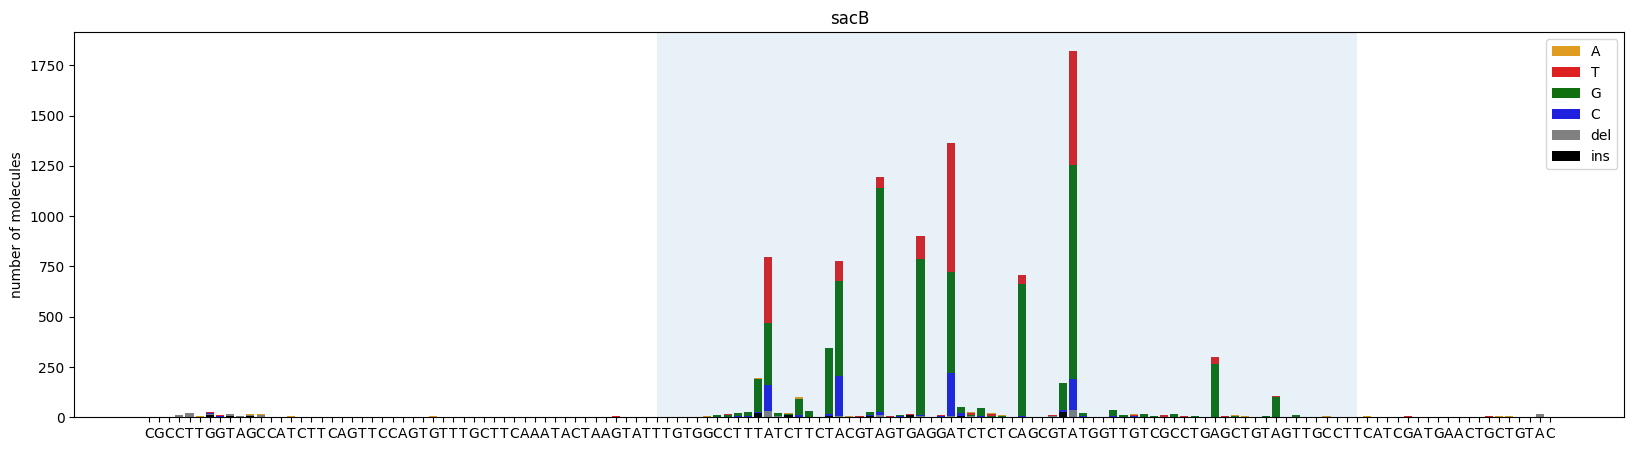

In [ ]:
ax = plot_mutations(gen_list, ref_seq, sample_name="sacB", plot_range=[0,139], TR_range=[50,119])

9.73


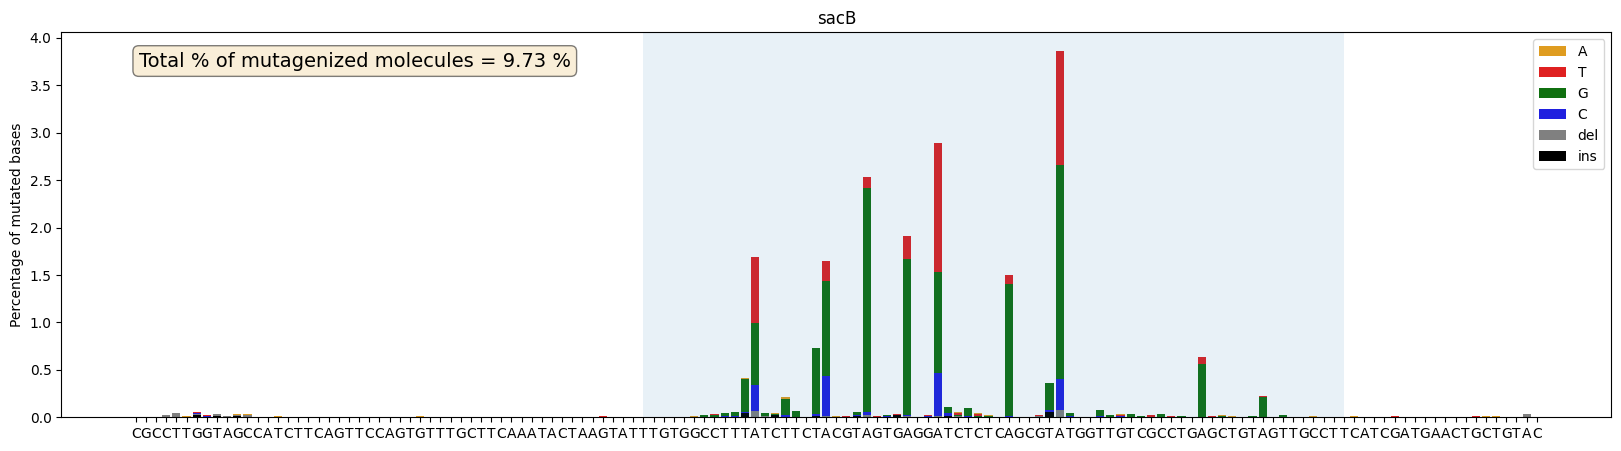

In [ ]:
ax,mut_perc=plot_mutations_percentage(gen_list, ref_seq, sample_name="sacB", plot_range=[0,139], TR_range=[50,119])
plt.show
print(mut_perc)

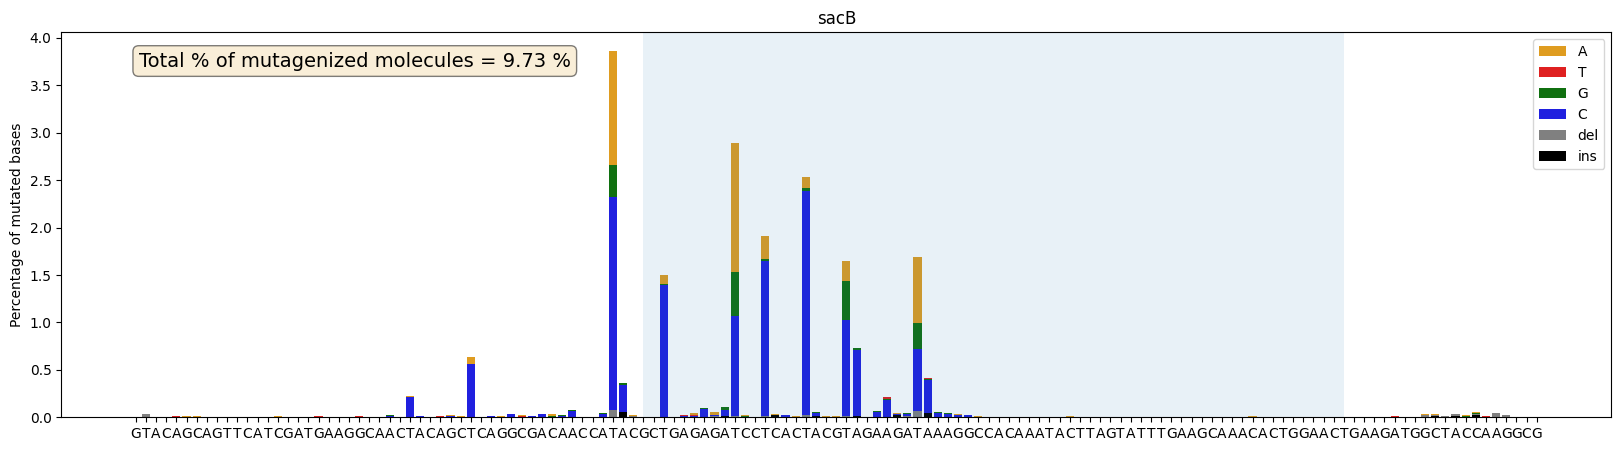

In [ ]:
ax = plot_mutations_percentage(gen_list, ref_seq, sample_name="sacB", plot_range=[0,139], TR_range=[50,119],rev_comp=True)

In [ ]:
#| export
def plot_mutations_percentage_protein(aa_mut_list, # list of genotypes. Each genotype is a tuple: (string representation of the genotype, number of molecules)
                                       ref_prot, # reference sequence
                                       plot_range=None,  # limits the plot to the specified range
                                       ax=None):
   
    def rgb_to_hex(rgb):
        return mcolors.to_hex(rgb)
    
    def get_colormap_palette(colormap_name, num_colors):
        colormap = cm.get_cmap(colormap_name, num_colors)
        return [rgb_to_hex(colormap(i)) for i in range(num_colors)]

    if not plot_range:
        plot_range=[0,len(ref_prot)]

    L = plot_range[1] - plot_range[0]
    ref_prot = ref_prot[plot_range[0]:plot_range[1]]

    count_geno = 0
    count_muta = 0
    for gen, n in aa_mut_list:
        count_geno += n

    symbols = [
        'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
        'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '*'
    ]

    mut_arrays = dict([(s, np.zeros(L)) for s in symbols])
    for gen, n in aa_mut_list:
        if gen != '':
            g = gen.split(',')
            count_muta += n
            for mut in g:
                if mut:
                    mut_from = mut[0]
                    ix = int(mut[1:-1])
                    k = mut[-1]
                    mut_arrays[k][ix] += n  

    for k in mut_arrays:
        mut_arrays[k] = 100 * (mut_arrays[k][plot_range[0]:plot_range[1]]) / count_geno

    labels = np.array(range(L))

    if ax==None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 6))

    y = sum(mut_arrays.values())
    colors = get_colormap_palette('tab20', 20) + ['black']
    for i, s in enumerate(symbols):
        sns.barplot(x=labels, y=y, color=colors[i], ax=ax, label=s)
        y -= mut_arrays[s]

    count_unique_amino = [0]*L
    for k in range(L):
        for amino in symbols:
            if mut_arrays[amino][k]>0:
                count_unique_amino[k]+=1

    ax.set_xticks(range(len(ref_prot)))

    xtick_labels = [f'{label1}\n\n{label2}' for label1, label2 in zip(list(ref_prot), count_unique_amino)]

    # Set the xtick labels
    ax.set_xticklabels(xtick_labels)

    # ax.set_xticklabels(list(ref_seq))
    ax.set_ylabel("Percentage of mutated amino acid")

    ax.legend()
    return ax


In [ ]:
aa_mut_list=get_aa_mut_list(gen_list,ref_seq,ori=-1) #the sacB gene is in reverse complement orientation compared to the VR so ori=-1 is needed
aa_mut_list[:10]

[('', 43341),
 ('Y22H', 351),
 ('H15Q', 277),
 ('D19E', 246),
 ('L17P', 200),
 ('V23A', 162),
 ('S11P', 117),
 ('D25E', 113),
 ('D19E,Y22H', 75),
 ('T16P', 61)]

/tmp/ipykernel_15151/3434536392.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(colormap_name, num_colors)


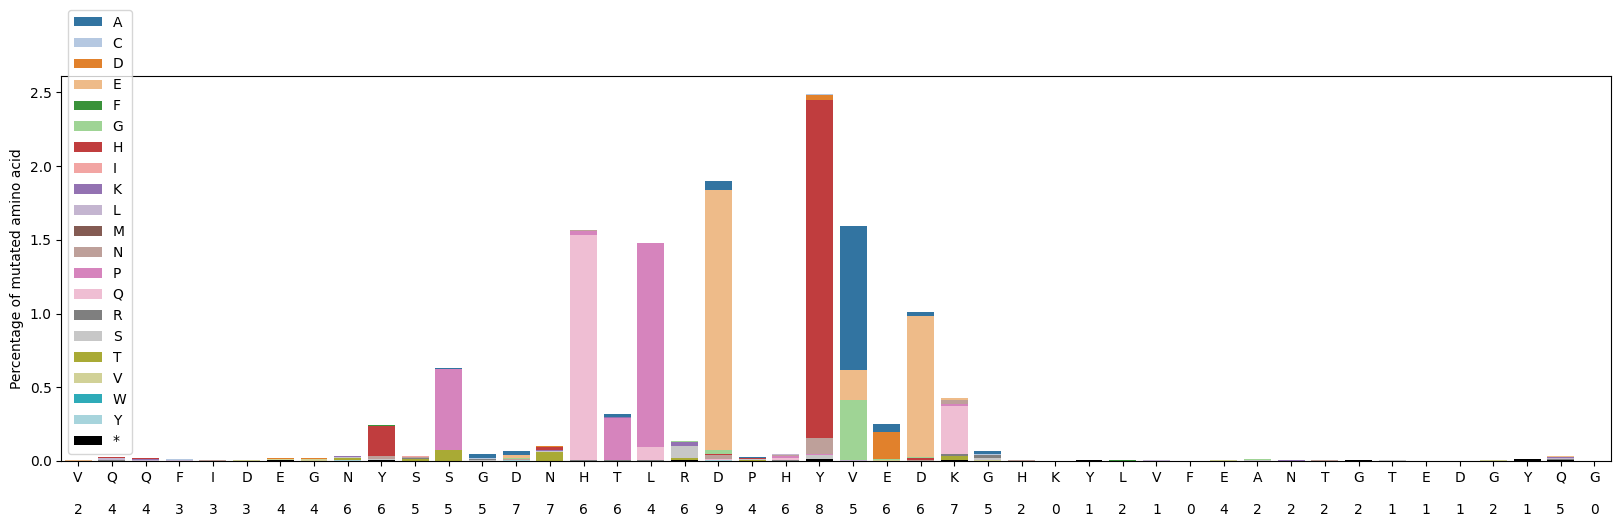

In [ ]:
ref_prot=Seq(ref_seq).reverse_complement()[:-1].translate() #the sacB gene is in reverse complement orientation compared to the VR

fig, ax = plt.subplots(1, 1, figsize=(20, 5))
plot_mutations_percentage_protein(aa_mut_list, ref_prot, ax=ax)
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()